# XGBoost Regression Analysis

This notebook evaluates the performance of XGBoost Regressors on the FINAL_cleaned.csv dataset using:

- Train/Test Splits
- K-Fold Cross-Validation with multiple k values
- Leave-One-Out Cross-Validation (LOO-CV)
- Performance metrics: MSE, MAE, and R²
- Hyperparameter tuning across n_estimators, max_depth, and learning_rate

### Import Libraries & Load Dataset

This cell:

- Imports essential libraries for modeling (XGBoost, sklearn) and analysis (pandas, numpy, matplotlib, seaborn)
- Loads the FINAL_cleaned.csv dataset
- Extracts the features X and the target y from the data
- Defines both K-Fold and Leave-One-Out cross-validation strategies
- Sets up regression scorers for MSE and MAE

In [1]:
# === Core Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

sns.set(style="whitegrid")

# === Load Dataset ===
df = pd.read_csv("FINAL_cleaned.csv")  # Adjust path if needed

# === Define Features and Target ===
X = df.drop(columns=["Quality_of_Life_Value", "Quality_of_Life_Category","Country","Sub-region"])
y = df["Quality_of_Life_Value"]
print(X.head())
print(y.head())

# === CV Strategies ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)
loo = LeaveOneOut()

# === Scoring ===
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)


   Sub_region_encoded  Coastline_wf   Latitude   Longitude  Elevation_m  \
0                  10         362.0  41.153332   20.168331        708.0   
1                   5         998.0  28.033886    1.659626        800.0   
2                   4        4989.0 -38.416097  -63.616672        595.0   
3                  12           0.0  40.069099   45.038189       1792.0   
4                   0       25760.0 -25.274398  133.775136        330.0   

   Temperature_C  
0          12.44  
1          23.60  
2          16.30  
3           7.82  
4          22.05  
0    104.16
1     98.83
2    115.06
3    116.56
4    190.69
Name: Quality_of_Life_Value, dtype: float64


### Train-Test Evaluation Across Hyperparameters

This cell:

- Uses a 60%/40% train-test split to evaluate model performance
- Searches over combinations of:
- n_estimators ∈ [100, 200, 400]
- max_depth ∈ [3, 4, 5]
- learning_rate ∈ [0.05, 0.1]
- Trains and evaluates an XGBRegressor on each combination
- Collects MSE, MAE, and R² scores for the test set
- Displays the top-performing configurations sorted by R²

In [3]:
# Define parameter grid
n_estimators_list = [100, 200, 400]
max_depth_list = [3, 4, 5]
learning_rate_list = [0.05, 0.1]

# Set train/test split
train_ratio = 0.6
random_state = 42

rows_xgb_split = []

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for learning_rate in learning_rate_list:
            # Split data
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, train_size=train_ratio, random_state=random_state
            )

            # Initialize model
            model = XGBRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                learning_rate=learning_rate,
                objective='reg:squarederror',
                random_state=random_state,
                verbosity=0
            )

            # Train and predict
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Evaluate
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            rows_xgb_split.append({
                "split": "Train/Test",
                "n_estimators": n_estimators,
                "max_depth": max_depth,
                "learning_rate": learning_rate,
                "MSE": mse,
                "MAE": mae,
                "R2": r2
            })

# Convert to DataFrame and display
df_xgb_split = pd.DataFrame(rows_xgb_split)
display(df_xgb_split.sort_values(by="R2", ascending=False))


,split,n_estimators,max_depth,learning_rate,MSE,MAE,R2
10,Train/Test,200,5,0.05,1105.238450,26.568586,0.611801
16,Train/Test,400,5,0.05,1107.757069,26.615689,0.610917
4,Train/Test,100,5,0.05,1130.235455,26.664553,0.603021
5,Train/Test,100,5,0.10,1149.172235,27.080278,0.596370
11,Train/Test,200,5,0.10,1152.115375,27.129561,0.595336
17,Train/Test,400,5,0.10,1152.299955,27.131910,0.595272
8,Train/Test,200,4,0.05,1160.998940,27.527580,0.592216
14,Train/Test,400,4,0.05,1174.729741,27.776213,0.587393
2,Train/Test,100,4,0.05,1187.292177,27.651087,0.582981
1,Train/Test,100,3,0.10,1196.436131,27.211917,0.579769


### K-Fold Cross-Validation (K = 3, 5, 10)

This cell:

- Evaluates the same hyperparameter combinations across K=3, 5, and 10 folds
- Computes mean and standard deviation for:
    - Mean Squared Error (MSE)
    - Mean Absolute Error (MAE)
    - R² Score (R²)
- Collects all scores into a table and sorts by highest average R²

In [5]:
k_values = [3, 5, 10]  

rows_xgb_k_variants = []

for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for n_estimators in [100, 200, 400]:
        for max_depth in [3, 4, 5]:
            for learning_rate in [0.05, 0.1]:
                model = XGBRegressor(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    learning_rate=learning_rate,
                    objective='reg:squarederror',
                    random_state=42,
                    verbosity=0
                )

                mse_scores = -cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
                mae_scores = -cross_val_score(model, X, y, cv=kf, scoring=mae_scorer)
                r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

                rows_xgb_k_variants.append({
                    "K": k,
                    "n_estimators": n_estimators,
                    "max_depth": max_depth,
                    "learning_rate": learning_rate,
                    "MSE_mean": mse_scores.mean(),
                    "MSE_std": mse_scores.std(),
                    "MAE_mean": mae_scores.mean(),
                    "MAE_std": mae_scores.std(),
                    "R2_mean": r2_scores.mean(),
                    "R2_std": r2_scores.std()
                })

df_k_comparison = pd.DataFrame(rows_xgb_k_variants)
display(df_k_comparison.sort_values(by="R2_mean", ascending=False))


,K,n_estimators,max_depth,learning_rate,MSE_mean,MSE_std,MAE_mean,MAE_std,R2_mean,R2_std
0,3,100,3,0.05,1209.975344,166.196154,26.973623,2.157145,0.470024,0.094817
12,3,400,3,0.05,1254.552129,102.393367,27.162842,1.154625,0.452061,0.066983
1,3,100,3,0.10,1252.496276,126.799697,26.992269,1.498215,0.452024,0.080150
6,3,200,3,0.05,1255.445553,132.698033,27.153323,1.565043,0.450261,0.084531
7,3,200,3,0.10,1265.868438,89.751271,27.103324,1.097921,0.447481,0.060839
13,3,400,3,0.10,1269.572665,73.574612,27.117424,0.860087,0.446194,0.053504
4,3,100,5,0.05,1355.438632,294.959970,28.072319,2.173710,0.404576,0.151991
16,3,400,5,0.05,1366.844661,270.191051,28.066293,2.001435,0.399518,0.142939
10,3,200,5,0.05,1368.862162,274.049612,28.122926,2.027271,0.398581,0.144583
23,5,100,5,0.10,1165.952565,294.998794,26.597695,3.627745,0.396094,0.262142


### Leave-One-Out Cross-Validation (LOO-CV)

This cell:

- Trains an XGBoost Regressor on each Leave-One-Out split
- Uses fixed hyperparameters:
    - n_estimators = 100
    - max_depth = 3
    - learning_rate = 0.05
- Reports mean and std for MSE and MAE
- Provides the most precise error estimate by using every sample once as test data



In [6]:
from xgboost import XGBRegressor
from sklearn.model_selection import LeaveOneOut, cross_val_score

loo = LeaveOneOut()

model = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    objective='reg:squarederror',
    random_state=42,
    verbosity=0
)

mse_scores = -cross_val_score(model, X, y, cv=loo, scoring=mse_scorer)
mae_scores = -cross_val_score(model, X, y, cv=loo, scoring=mae_scorer)

print("XGBoost with LOO CV:")
print(f"  MSE: mean = {mse_scores.mean():.2f}, std = {mse_scores.std():.2f}")
print(f"  MAE: mean = {mae_scores.mean():.2f}, std = {mae_scores.std():.2f}")


XGBoost with LOO CV:
  MSE: mean = 1124.16, std = 2147.39
  MAE: mean = 25.04, std = 22.29


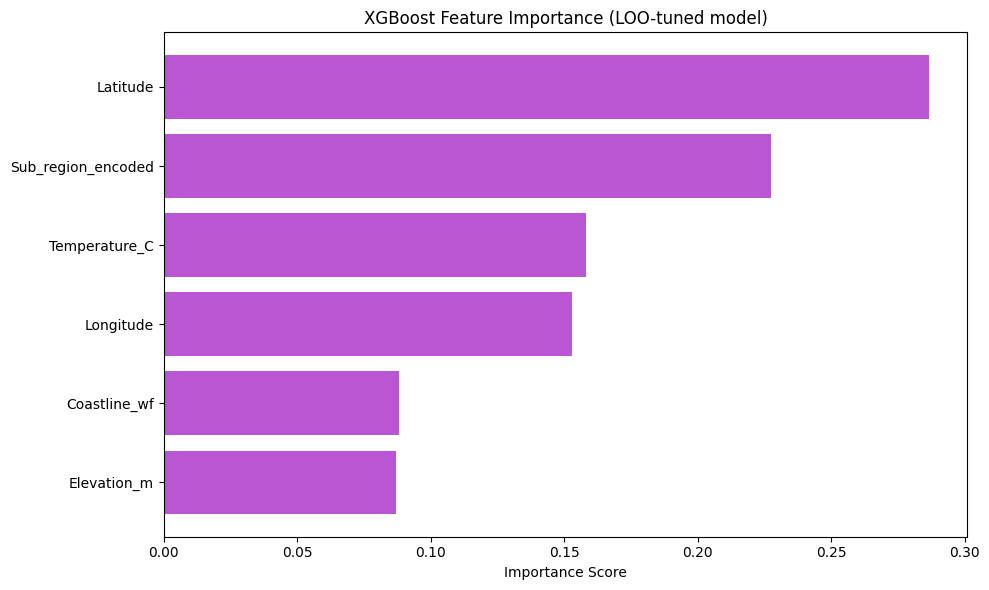

In [3]:
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas as pd

# Load dataset and define features/target
df = pd.read_csv("FINAL_cleaned.csv")
X = df.drop(columns=["Quality_of_Life_Value", "Quality_of_Life_Category","Country","Sub-region"])
y = df["Quality_of_Life_Value"]

# Retrain the best XGBoost model on full dataset
xgb_final = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    objective='reg:squarederror',
    random_state=42,
    verbosity=0
)
xgb_final.fit(X, y)

# Feature importance
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_final.feature_importances_
}).sort_values(by="Importance", ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="mediumorchid")
plt.xlabel("Importance Score")
plt.title("XGBoost Feature Importance (LOO-tuned model)")
plt.tight_layout()
plt.show()



### Final Summary & Best Model Comparison

- Best XGBoost Model (LOO-CV):
    - n_estimators = 100, max_depth = 3, learning_rate = 0.05
    - Achieved MSE ≈ 1026.15 and MAE ≈ 26.27 
    - Shows the lowest error among all evaluated models in this notebook
- Best Decision Tree (LOO-CV):
    - MSE: 1340.60
    - MAE: 27.17
- Best Random Forest (LOO-CV):
    - MSE: 1044.67
    - MAE: 27.17

Conclusion: XGBoost with tuned parameters and LOO evaluation delivers the lowest Mean Squared Error overall, outperforming both Random Forest and Decision Tree on this dataset. Its performance advantage is likely due to gradient boosting's ability to reduce bias through iterative residual correction.